#### <span style="color:#AD07FF"> This notebook creates prediction about is user on 180 days program or not. It's important becouse we can detect people who is going to use app at least 180 days and it's really great information

In [1]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,mean_squared_error, r2_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor

%matplotlib inline

In [2]:
# The data is large and this command will help us to see the whole result 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
data = pd.read_csv('../data/data_for_predict_180days_diet.csv')

In [4]:
data["is_180_diet"].value_counts()

0.0    2219
1.0    1524
Name: is_180_diet, dtype: int64

#### <span style="color:#00CC00"> As you can see, the people who were on 180 day program are twice less than the people who were not.

#### <span style="color:#FF7B07"> Let's drop unused columns becouse if we won't do this, there will be approximately 200 features ! :) <br>  First of all, our new features containing "diff" consists both "goal" and "total " becouse it's their difference and I think in my algorithm differences between total and goal are more important then these columns itself. So I'm gonna drop them .

In [5]:
col1 = list(filter(lambda x:   ("goal" in x) or ("total" in x)  or ("sugar" in x), data.columns))
X = data.drop(columns=['is_180_diet','logged_frequency','user_id','days_missed'])
X = X.drop(columns=col1)
y = data['is_180_diet']

#### <span style="color:#00CC00"> Look's Like our data needs to be balanced . <br>So let's do this with smote

In [6]:
def prepare_data(X,y,columnsTobeDropped):
    if(columnsTobeDropped):
        X = X.drop(columns=columnsTobeDropped)
    X_train, X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
    sm = SMOTE(random_state=42)
    X_train_s,y_train_s =sm.fit_sample(X_train,y_train)
    X_test_s,y_test_s =sm.fit_sample(X_test,y_test)
    return X_train_s, y_train_s, X_test_s,y_test_s

In [7]:
def classification_metrics(yTrueTrain,yPredictTrain,yTrueTest,yPredictTest,heatmap=False)->None:
    """
    this function prints accuracy, precision, recall, F1 scre 
    and create confusion matrix  heatmap for both train and test sets
    
    Arguments:
    yTrueTrain -- the true value of prediction from the train set
    yPredictTrain -- predicted value from the train set
    yTrueTest -- he true value of prediction from the test set
    yPredictTest -- predicted value from the test set
    heatmap -- boolean which tells us if plot heatmap or not
    
    Returns:
    None
    """
    print("train data:\t  "+ "\t"*6+ "test data:\t\n")
    print(("accuracy:\t {0} "+ "\t"*6+ "accuracy:\t {1}").format(accuracy_score(yTrueTrain, yPredictTrain).round(2), 
                                                                 accuracy_score(yTrueTest, yPredictTest).round(2)))
          
    print(("precision:\t {0} "+ "\t"*6+ "precision:\t {1}").format(precision_score(yTrueTrain, yPredictTrain).round(2), 
                                                                   precision_score(yTrueTest, yPredictTest).round(2)))
    
    print(("recall:\t\t {0} "+ "\t"*6+ "recall:\t\t {1}").format(recall_score(yTrueTrain, yPredictTrain).round(2), 
                                                                 recall_score(yTrueTest, yPredictTest).round(2)))
    
    print(("F1:\t\t {0} "+ "\t"*6+ "F1:\t\t {1}").format(f1_score(yTrueTrain, yPredictTrain).round(2), 
                                                         f1_score(yTrueTest, yPredictTest).round(2)))
    if(heatmap):
        f, ax  = plt.subplots(1,2,figsize = (18,6))
        sns.heatmap(confusion_matrix(yTrueTrain,yPredictTrain),cmap='coolwarm',annot=True,ax=ax[0])
        sns.heatmap(confusion_matrix(yTrueTest,yPredictTest),cmap='coolwarm',annot=True,ax=ax[1])
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [8]:
def depthChecker(columnsTobeDropped,X,y):
    X_train, y_train, X_test,y_test =prepare_data(X,y,columnsTobeDropped);
    cv = KFold(n_splits=10,shuffle = True,random_state=42)
    accuracies = list()
    depth_range = range(1, 10)
    # Testing max_depths from 1 to 10
    for depth in depth_range:
        fold_accuracy = []
        tree_model = DecisionTreeClassifier(max_depth = depth,random_state = 42)
        for train_fold, valid_fold in cv.split(X_train):
            f_train_x = X_train[train_fold] 
            f_train_y = y_train[train_fold]
          
            f_valid_x = X_train[valid_fold]
            f_valid_y = y_train[valid_fold]

            model = tree_model.fit(X = f_train_x,y = f_train_y) # We fit the model with the fold train data
            valid_acc = model.score(X = f_valid_x,y = f_valid_y) # We calculate accuracy with the fold validation data
            fold_accuracy.append(valid_acc)
        avg = sum(fold_accuracy)/len(fold_accuracy)
        accuracies.append(avg)
      
    # Just to show results conveniently
    df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
    df = df[["Max Depth", "Average Accuracy"]]
    print(df.to_string(index=False))

train data:	  						test data:	

accuracy:	 0.68 						accuracy:	 0.67
precision:	 0.67 						precision:	 0.66
recall:		 0.73 						recall:		 0.71
F1:		 0.7 						F1:		 0.68


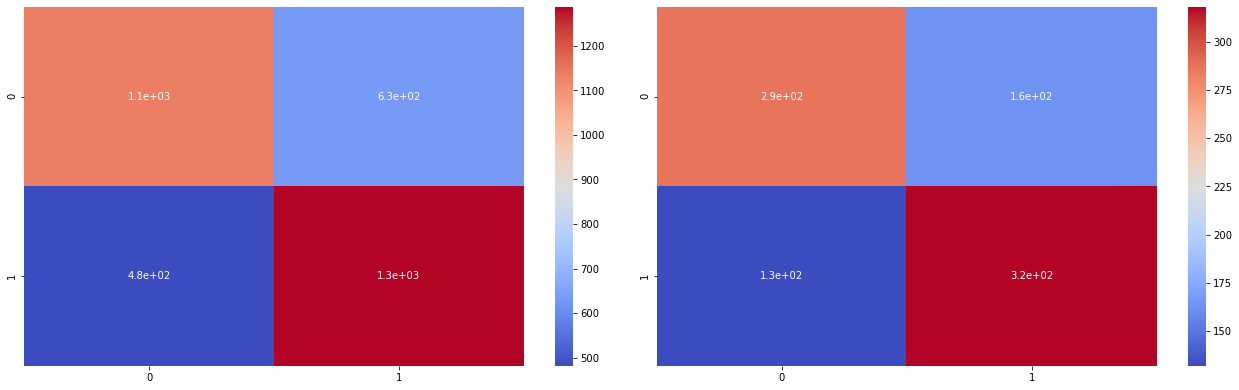

In [9]:
X_train, y_train, X_test,y_test =prepare_data(X,y,{})
decision_tree = DecisionTreeClassifier(max_depth=3,random_state=42)
decision_tree.fit(X_train, y_train)

# Predicting results for test dataset
y_pred_train = decision_tree.predict(X_train)
y_pred_test = decision_tree.predict(X_test)
classification_metrics(y_train,y_pred_train,y_test,y_pred_test,True)

#### <span style="color:#FF7B07"> In the previous algorithm (predict reach goal) we saw with pca that the perfect quantity of columns is approximateli 10-15.<br> So I'm gonna follow this idea and I'm gonna drop some days and let's see if we'll improve our acc

train data:	  						test data:	

accuracy:	 0.67 						accuracy:	 0.7
precision:	 0.68 						precision:	 0.7
recall:		 0.67 						recall:		 0.72
F1:		 0.67 						F1:		 0.71


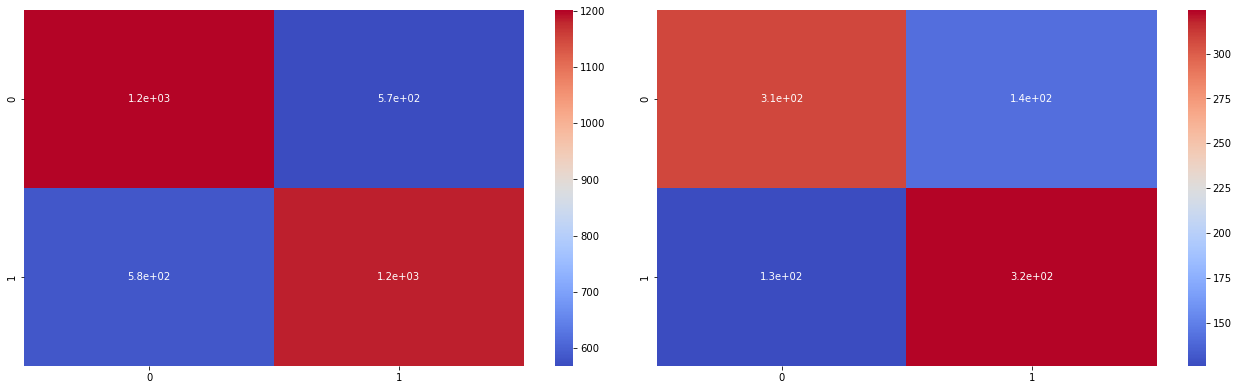

In [10]:
col2= list(filter(lambda x:   ("_2" in x ) or ("_3" in x) or ("_4" in x) or ("_5" in x) or ("_6" in x) or ("_7" in x) or ("_8" in x) ,X.columns))
X_train, y_train, X_test,y_test =prepare_data(X,y,col2)
decision_tree = DecisionTreeClassifier(max_depth=3,random_state=42)
decision_tree.fit(X_train, y_train)

# Predicting results for test dataset
y_pred_train = decision_tree.predict(X_train)
y_pred_test = decision_tree.predict(X_test)
classification_metrics(y_train,y_pred_train,y_test,y_pred_test,True)

In [11]:
model = DecisionTreeRegressor()
col2= list(filter(lambda x:   ("_2" in x ) or ("_3" in x) or ("_4" in x) or ("_5" in x) or ("_6" in x) or ("_7" in x) or ("_8" in x) ,X.columns))
X_train, y_train, X_test,y_test =prepare_data(X,y,col2)
model.fit(X_train, y_train)
importance = model.feature_importances_
importance_df = pd.DataFrame(columns=['feature','importance'])
importance_df['feature'] = X.drop(columns=col2).columns
importance_df['importance'] = importance
importance_df.sort_values(by=['importance'],ascending = False)

,feature,importance
14,foods_len_9,0.126784
1,healtyDistrib,0.069655
3,carbs_diff,0.068995
2,calories_diff,0.065760
6,sodium_diff,0.061724
4,fat_diff,0.061650
5,protein_diff,0.051339
0,foods_len,0.047744
20,sodium_diff_9,0.045123
7,foods_len_1,0.042863


C:\Users\Raffael Kalandadze\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train data:	  						test data:	

accuracy:	 0.66 						accuracy:	 0.69
precision:	 0.66 						precision:	 0.68
recall:		 0.68 						recall:		 0.72
F1:		 0.67 						F1:		 0.7


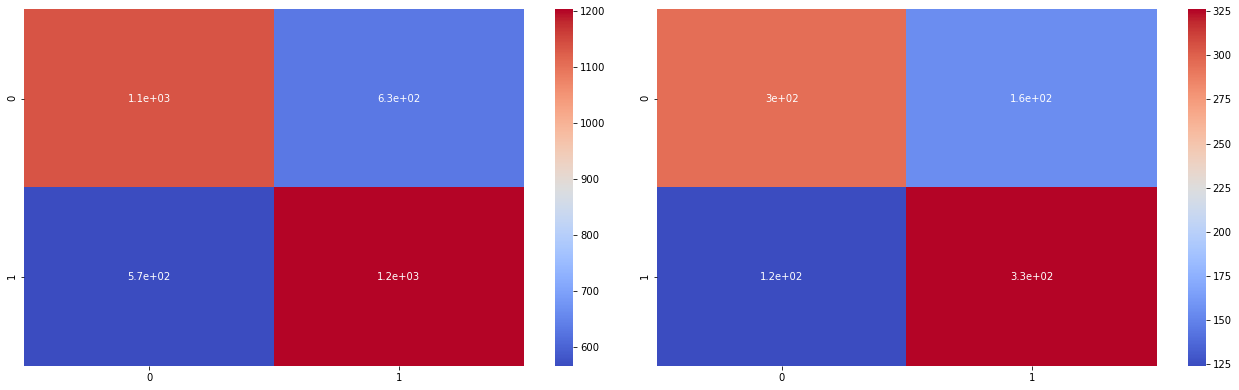

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
classification_metrics(y_train,clf.predict(X_train),y_test,clf.predict(X_test),True)

#### <span style="color:#00CC00"> As we see without unused days, we improved our accuracy !<br>Let's check how another algorithms behave with our data :) 

In [14]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC()

train data:	  						test data:	

accuracy:	 0.65 						accuracy:	 0.7
precision:	 0.65 						precision:	 0.69
recall:		 0.67 						recall:		 0.73
F1:		 0.66 						F1:		 0.71


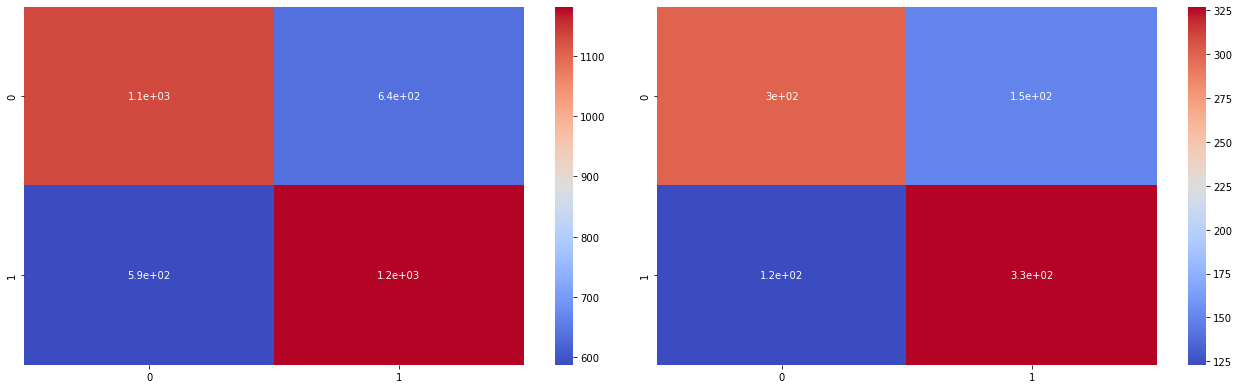

In [15]:
classification_metrics(y_train,svclassifier.predict(X_train),y_test,svclassifier.predict(X_test),True)

#### <span style="color:#FF7B07"> Let's see which params to use for SVM

In [16]:
from sklearn.model_selection import GridSearchCV 
# defining parameter range 
param_grid = {'C': [10, 100],  
              'gamma': [1, 0.1, 0.01], 
              'kernel': ['linear']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=10, gamma=1, kernel=linear ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........ C=10, gamma=1, kernel=linear, score=0.643, total=   2.6s
[CV] C=10, gamma=1, kernel=linear ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ........ C=10, gamma=1, kernel=linear, score=0.660, total=   1.4s
[CV] C=10, gamma=1, kernel=linear ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV] ........ C=10, gamma=1, kernel=linear, score=0.654, total=   1.5s
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.670, total=   1.6s
[CV] C=10, gamma=1, kernel=linear ....................................
[CV] ........ C=10, gamma=1, kernel=linear, score=0.638, total=   1.9s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.643, total=   2.6s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.660, total=   1.5s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.654, total=   1.5s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] ...... C=10, gamma=0.1, kernel=linear, score=0.670, total=   1.6s
[CV] C=10, gamma=0.1, kernel=linear ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  3.3min finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [10, 100], 'gamma': [1, 0.1, 0.01],
                         'kernel': ['linear']},
             verbose=3)

In [17]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear',gamma=1,C=10)
svclassifier.fit(X_train, y_train)

SVC(C=10, gamma=1, kernel='linear')

train data:	  						test data:	

accuracy:	 0.65 						accuracy:	 0.68
precision:	 0.63 						precision:	 0.65
recall:		 0.74 						recall:		 0.78
F1:		 0.68 						F1:		 0.71


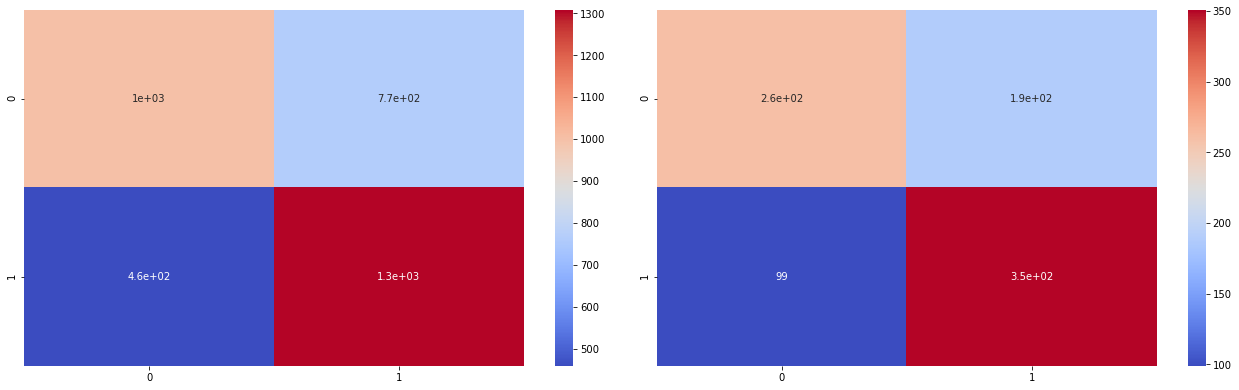

In [18]:
classification_metrics(y_train,svclassifier.predict(X_train),y_test,svclassifier.predict(X_test),True)

# <span style="color:#FF7B07"><div align="center">**Result** 

#### <span style="color:#FF7B07"> The results are amazing, we can guess if the person is going to be on 180 day program with only her/his first and 10nd day results and our new features ! 